[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/NeuroGrid/pubhealth/blob/main/pubhealth-eda.ipynb)

In [1]:
!pip install datasets transformers evaluate imbalanced-learn umap-learn wandb GPUtil seaborn pandas numpy

In [2]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Pubhealth Dataset

PUBHEALTH is a comprehensive dataset for explainable automated fact-checking of public health claims. Each instance in the PUBHEALTH dataset has an associated veracity label (true, false, unproven, mixture). Furthermore each instance in the dataset has an explanation text field. The explanation is a justification for which the claim has been assigned a particular veracity label.

Dataset link: https://huggingface.co/datasets/health_fact

In [5]:
from datasets import load_dataset

health_fact = load_dataset('health_fact')

Found cached dataset health_fact (/Users/samueljoseph/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19)


  0%|          | 0/3 [00:00<?, ?it/s]

Not mentioned in the dataset card on Hugging Face, is that as well as the four veracity labels, there is an additional "invalid" label which is represented with a -1.  

These need to be removed from the train, validation and test sets to avoid problems during training ML models.

In [6]:
# Filter out instances with a -1 label
health_fact['train'] = health_fact['train'].filter(lambda x: x['label'] != -1)
health_fact['validation'] = health_fact['validation'].filter(lambda x: x['label'] != -1)
health_fact['test'] = health_fact['test'].filter(lambda x: x['label'] != -1)

Loading cached processed dataset at /Users/samueljoseph/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19/cache-873b578b91e1c3b4.arrow
Loading cached processed dataset at /Users/samueljoseph/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19/cache-fd8b03ec8e0cf76c.arrow
Loading cached processed dataset at /Users/samueljoseph/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19/cache-9e2141adfd67e463.arrow


Let's have a quick look at the sort of data we have in the dataset by converting to a Pandas format, adding in a column for the label names

In [7]:
health_fact.set_format(type="pandas")
df = health_fact["train"][:]

def label_int2str(row):
    if row == -1:
        return 'invalid'
    return health_fact["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)

df.head()

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,label_name
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,0,"Foreign Policy, PunditFact, Newt Gingrich,",false
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,1,"Screening,WebMD,women's health",mixture
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,1,"Association/Society news release,Cancer",mixture
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,2,"Cancer,WebMD,women's health",true
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,2,,true


## Frequency of the Different Classes

Having added the label names, we can now easily see the relative frequency of the different classes

Text(0.5, 1.0, 'Frequency of Classes')

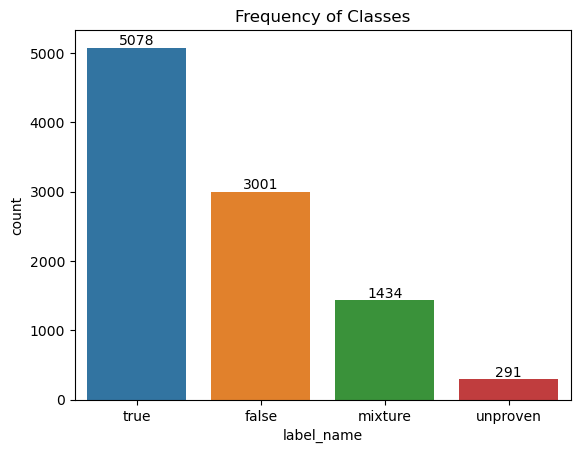

In [11]:
ax = sns.countplot(x='label_name', data=df, order = df['label_name'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.title("Frequency of Classes")

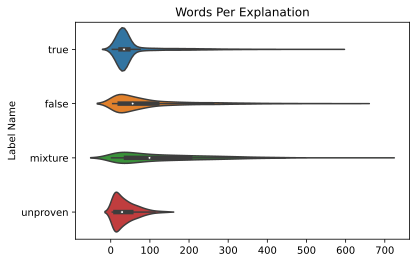

In [13]:
def words_per_plot(column_name ='explanation'):
    name = column_name.title()
    title = f'Words Per {name}'.replace('_', ' ')
    df[title] = df[column_name].str.split().apply(len)
    sns.violinplot(x=df[title], y=df['label_name'], data=df, order = df['label_name'].value_counts().index)
    plt.title(title)
    plt.xlabel("")
    plt.ylabel("Label Name")

words_per_plot()

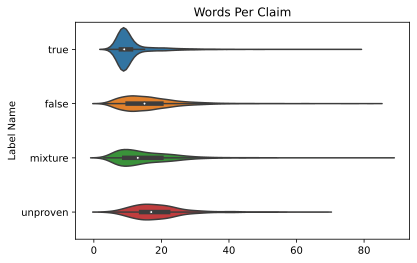

In [15]:
words_per_plot('claim')

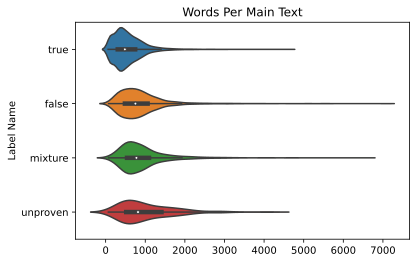

In [14]:
words_per_plot('main_text')

## Distribution of Dates

<Axes: xlabel='label_name', ylabel='year'>

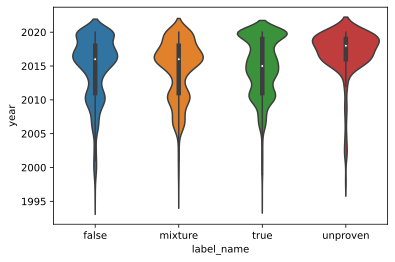

In [16]:
df_copy = df.copy()
df_copy.loc[:,'date'] = pd.to_datetime(df['date_published'], format='%B %d, %Y', errors='coerce')

df_copy = df_copy.copy()
df_copy.loc[:,'year'] = df_copy['date'].dt.year

# Create a boxplot of the date ranges for each type of label_name using Seaborn
sns.violinplot(x=df_copy['label_name'], y='year', data=df_copy)

Below we look at heatmaps at the most frequent sources, fact checkers and subjects for each of the different classes

In [117]:
import re
# Define a function to split a list of names on comma, "and", or ampersand
def split_names(names):
    # Split on comma or " and " or " & "
    pattern = r',|\s+(and|And)\s+|\s+&(\s+amp;)?\s+'
    split_names = re.split(pattern, names)
    # Clean up the resulting names
    cleaned_names = [name.strip() for name in split_names if name]
    return cleaned_names

<Axes: xlabel='label_name', ylabel='f{column_name}_clean'>

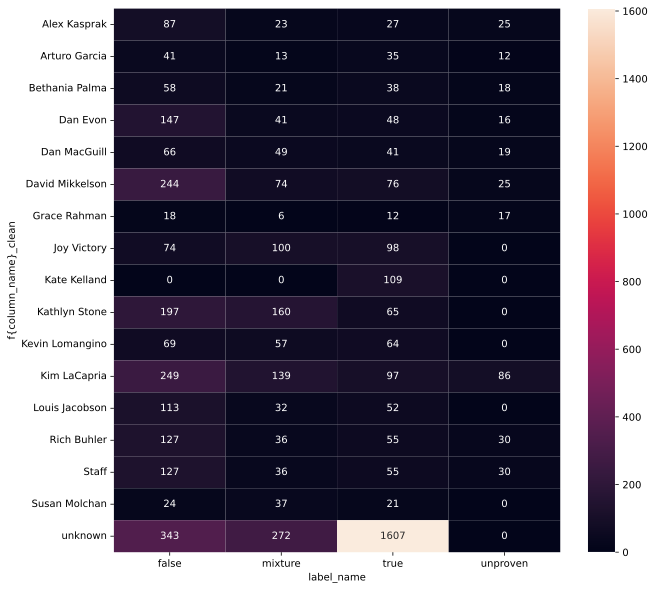

In [171]:
def create_pivot_for_heatmap(column_name = 'fact_checkers'):
    new_column_name = 'f{column_name}_clean'
    df[new_column_name] = df[column_name].apply(split_names).apply(lambda list: [*map(lambda name: name.strip() if name.strip() != '' else 'unknown', list)])
    exploded_df = df.explode(new_column_name)

    # Drop rows with missing fact checker values
    exploded_df = exploded_df.dropna(subset=[new_column_name])
    # exploded_df = exploded_df[~exploded_df[new_column_name].isin(['MD', 'MPH', 'PhD', 'MA', 'MS', 'MPA', 'DrPH', 'FACS', 'MHS', 'MBBS', 'FAAFP', 'MSJ'])] # could drop less than len 4?
    exploded_df = exploded_df[exploded_df[new_column_name].str.len() > 4] 

    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #     print(exploded_df[new_column_name].value_counts(normalize=False, dropna=False))
    # exploded_df[new_column_name] = exploded_df[new_column_name].str.split().apply(lambda names: ' '.join(names).strip())
    # exploded_df[new_column_name] = exploded_df[new_column_name].apply(lambda name: name if (name != '') and (name != ' ') else 'unknown')
    # exploded_df.head()

    # Group the data by label_name and fact_checkers and count the number of rows in each group
    df_count = exploded_df.groupby(['label_name', new_column_name]).size().reset_index(name='frequency')
    df_count['frequency'] = df_count['frequency'].astype(int)
    # df_count.head()
    # df_count.info()

    # # print(df_count['frequency'].dtype)
    # # print(df_count['frequency'].unique())

    df_count['frequency'] = pd.to_numeric(df_count['frequency'], errors='coerce')

    df_pivot = df_count.pivot(index=new_column_name, columns='label_name', values='frequency')
    df_pivot = df_pivot.fillna(0)

    # df_pivot
    # # Get the top 10 fact checkers for each label_name
    top_fact_checkers = []
    for label_name in df_pivot.columns:
        array = list(df_pivot[label_name].nlargest(10).index)
        for element in array:
            top_fact_checkers.append(element)

    # print(top_fact_checkers)
    # # # df_count['fact_checkers'][0]
    # print(df_count.head())

    # print(df_pivot.head(20))

    df_filtered = df_count[df_count[new_column_name].isin(top_fact_checkers)]
    df_filtered

    df_pivot = df_filtered.pivot(index=new_column_name, columns='label_name', values='frequency')
    return df_pivot.fillna(0)
# label_list = list(top_fact_checkers.keys())
# label_list
# # Filter the data to show only the top 10 fact checkers for each label_name
# df_filtered = df_count[df_count[new_column_name].isin(top_fact_checkers[df_count['label_name']])]
# df_filtered = df_count[df_count[new_column_name].isin(top_fact_checkers.loc[top_fact_checkers['label_name'].isin(label_list), 'fact_checker'].tolist())]
df_pivot = create_pivot_for_heatmap()
fig, ax = plt.subplots(figsize=(10, 10))

# # Create a heatmap of the frequency with which each fact checker has been involved in each type of claim
sns.heatmap(data=df_pivot, annot=True, fmt='g')


<Axes: xlabel='label_name', ylabel='f{column_name}_clean'>

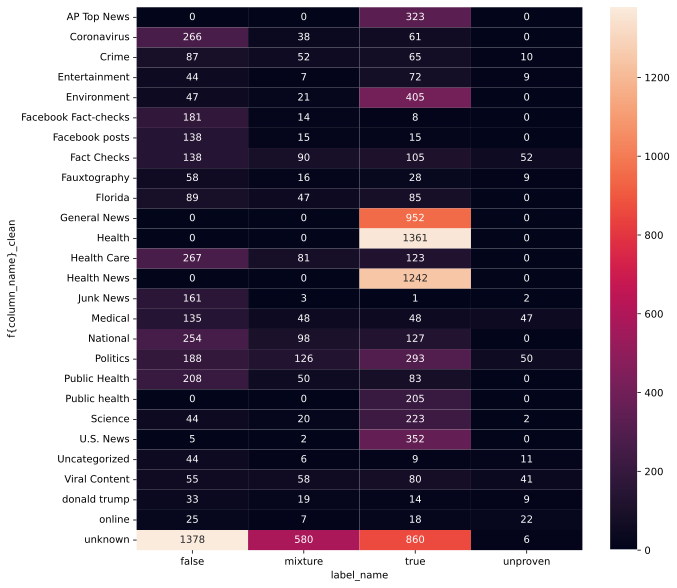

In [172]:
df_pivot = create_pivot_for_heatmap('subjects')
fig, ax = plt.subplots(figsize=(10, 10))

# # Create a heatmap of the frequency with which each fact checker has been involved in each type of claim
sns.heatmap(data=df_pivot, annot=True, fmt='g')


<Axes: xlabel='label_name', ylabel='f{column_name}_clean'>

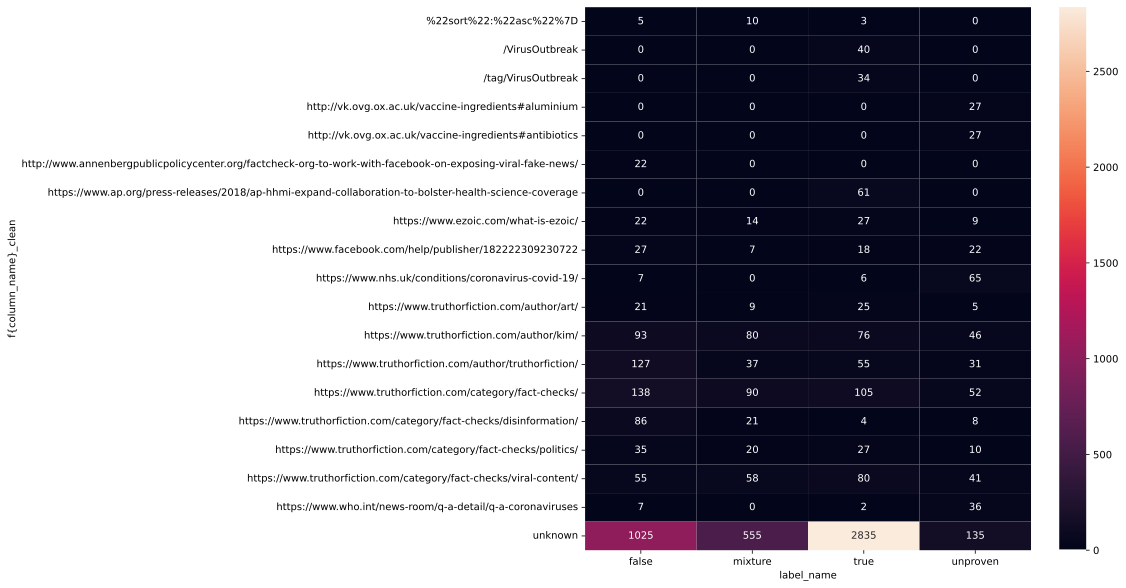

In [174]:
df_pivot = create_pivot_for_heatmap('sources')
fig, ax = plt.subplots(figsize=(10, 10))

# # Create a heatmap of the frequency with which each fact checker has been involved in each type of claim
sns.heatmap(data=df_pivot, annot=True, fmt='g')

We can see some patterns here in that claims where the fact checkers were unknown tended to be true, and certain fact checkers were more involved in claims of one kind than another.  In addition certain subjects are much more likely to be true, e.g. health care, while unknown sources seems to be an indicator of true stories.  These aspects likely reflect the trends within the different datasets being gathered into this dataset, but it's interesting to consider whether we could use these distribtions to predict the veracity of the claim to some degree of accuracy.

In [13]:
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [14]:
# checkpoint = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# tokenized_explanations = tokenizer(health_fact["train"]["explanation"], max_length=512, truncation=True, padding=True, return_tensors="pt")

In [15]:
health_fact.reset_format()

In [16]:
def tokenize(batch):
    return tokenizer(batch['explanation'], truncation=True, padding=True)

In [17]:
health_fact_encoded = health_fact.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [18]:
print(health_fact_encoded["train"].column_names)

['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects', 'input_ids', 'attention_mask']


In [19]:
import torch
from transformers import AutoModel

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [21]:
health_fact_encoded.set_format('torch', columns=["input_ids", "attention_mask", "label"])

In [22]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()  

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=76ff50770de931a7d8cb0349dd84b5543393249a1c9e3d86fd78309a63adb4e2
  Stored in directory: /root/.cache/pip/wheels/b1/e7/99/2b32600270cf23194c9860f029d3d5db075f250bc39028c045
Successfully built GPUtil
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
----------

In [23]:
del df

In [24]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [25]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()  

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 |  0% |  6% |


In [ ]:
health_fact_hidden = health_fact_encoded.map(extract_hidden_states, batched=True, batch_size=100)

  0%|          | 0/99 [00:00<?, ?ba/s]

In [ ]:
import numpy as np

X_train = np.array(health_fact_hidden["train"]["hidden_state"])
X_valid = np.array(health_fact_hidden["validation"]["hidden_state"])
y_train = np.array(health_fact_hidden["train"]["label"])
y_valid = np.array(health_fact_hidden["validation"]["label"])
X_train.shape, X_valid.shape

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(5,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Greens"]
labels = health_fact["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)
